# <p style="text-align: center;">IR Project</p>
## <p style="text-align: center;">Pulp Fiction Group</p>
## <p style="text-align: center;">Filippo Lucchesi, Francesco Pio Crispino, Martina Speciale</p>

## Introduction
The goal of this project is to create an IR system for retrieving information from a particular dataset. We will analyze its performance step-by-step, both in regards to time of execution and results obtained.
* ### Parallelization

We will propose our implementation of a parallelized method for the building of the Inverted Index and another parallelized method for query processing.
* ### Scoring algorithms comparison

We will also compare the results provided by the TF-IDF and BM25 scoring algorithms, along with experimenting with some possible improvements.
* ### Caching

We will discuss the usefulness of different types of caching, again with a performance comparison.
* ### Relevance-feedback

Finally, we will implement our own version of a relevance-feedback algorithm, inspired by the Rocchio algorithm.

**<p style="text-align: center;">! IMPORTANT !</p>**
This notebook was run on Kaggle's notebook environment. Execution on any other platform is likely to cause errors and exceptions.

## Imports and installations

In [1]:
!pip install -q ir_datasets ir-measures scikit-learn dill pybind11 tqdm pympler python-terrier

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 15.3 MB/s eta 0:00:00


In [2]:
import traceback
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
import subprocess
try:
    nltk.data.find('wordnet.zip')
except:
    '''Kaggle specific install path for nltk'''
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...


In [3]:
# IMPORTS
import os
import ir_datasets
import ir_measures
from ir_measures import *
import pyterrier as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import hashlib
import heapq
import time
from tqdm import tqdm
import array

import collections
from collections import defaultdict
from collections import Counter


import re
import string
import humanize
import sys

import dill

## lru_cache Decorator

In this project we will make use of caching to improve the performance of some key operations. We reported the entire definition of the decorator we will use, `lru_cache`, in the following cell. We also made a small change: the method `cache_info()` now also returns the size of the cache in bytes, so that we can get an idea of how expensive caching is in terms of occupied memory.

In [4]:
from collections import namedtuple
import psutil
from itertools import islice
from functools import RLock, update_wrapper, namedtuple
_CacheInfo = namedtuple("CacheInfo", ["hits", "misses", "maxsize", "currsize"])

class _HashedSeq(list):
    """ This class guarantees that hash() will be called no more than once
        per element.  This is important because the lru_cache() will hash
        the key multiple times on a cache miss.

    """

    __slots__ = 'hashvalue'

    def __init__(self, tup, hash=hash):
        self[:] = tup
        self.hashvalue = hash(tup)

    def __hash__(self):
        return self.hashvalue

def _make_key(args, kwds, typed,
             kwd_mark = (object(),),
             fasttypes = {int, str},
             tuple=tuple, type=type, len=len):
    """Make a cache key from optionally typed positional and keyword arguments

    The key is constructed in a way that is flat as possible rather than
    as a nested structure that would take more memory.

    If there is only a single argument and its data type is known to cache
    its hash value, then that argument is returned without a wrapper.  This
    saves space and improves lookup speed.

    """
    # All of code below relies on kwds preserving the order input by the user.
    # Formerly, we sorted() the kwds before looping.  The new way is *much*
    # faster; however, it means that f(x=1, y=2) will now be treated as a
    # distinct call from f(y=2, x=1) which will be cached separately.
    key = args
    if kwds:
        key += kwd_mark
        for item in kwds.items():
            key += item
    if typed:
        key += tuple(type(v) for v in args)
        if kwds:
            key += tuple(type(v) for v in kwds.values())
    elif len(key) == 1 and type(key[0]) in fasttypes:
        return key[0]
    return _HashedSeq(key)

def lru_cache(maxsize=128, typed=False):
    """Least-recently-used cache decorator.

    If *maxsize* is set to None, the LRU features are disabled and the cache
    can grow without bound.

    If *typed* is True, arguments of different types will be cached separately.
    For example, f(decimal.Decimal("3.0")) and f(3.0) will be treated as
    distinct calls with distinct results. Some types such as str and int may
    be cached separately even when typed is false.

    Arguments to the cached function must be hashable.

    View the cache statistics named tuple (hits, misses, maxsize, currsize)
    with f.cache_info().  Clear the cache and statistics with f.cache_clear().
    Access the underlying function with f.__wrapped__.

    See:  https://en.wikipedia.org/wiki/Cache_replacement_policies#Least_recently_used_(LRU)

    """

    # Users should only access the lru_cache through its public API:
    #       cache_info, cache_clear, and f.__wrapped__
    # The internals of the lru_cache are encapsulated for thread safety and
    # to allow the implementation to change (including a possible C version).

    if isinstance(maxsize, int):
        # Negative maxsize is treated as 0
        if maxsize < 0:
            maxsize = 0
    elif callable(maxsize) and isinstance(typed, bool):
        # The user_function was passed in directly via the maxsize argument
        user_function, maxsize = maxsize, 128
        wrapper = _lru_cache_wrapper(user_function, maxsize, typed, _CacheInfo)
        wrapper.cache_parameters = lambda : {'maxsize': maxsize, 'typed': typed}
        return update_wrapper(wrapper, user_function)
    elif maxsize is not None:
        raise TypeError(
            'Expected first argument to be an integer, a callable, or None')

    def decorating_function(user_function):
        wrapper = _lru_cache_wrapper(user_function, maxsize, typed, _CacheInfo)
        wrapper.cache_parameters = lambda : {'maxsize': maxsize, 'typed': typed}
        return update_wrapper(wrapper, user_function)

    return decorating_function

def _lru_cache_wrapper(user_function, maxsize, typed, _CacheInfo):
    # Constants shared by all lru cache instances:
    sentinel = object()          # unique object used to signal cache misses
    make_key = _make_key         # build a key from the function arguments
    PREV, NEXT, KEY, RESULT = 0, 1, 2, 3   # names for the link fields

    cache = {}
    hits = misses = 0
    full = False
    cache_get = cache.get    # bound method to lookup a key or return None
    cache_len = cache.__len__  # get cache size without calling len()
    lock = RLock()           # because linkedlist updates aren't threadsafe
    root = []                # root of the circular doubly linked list
    root[:] = [root, root, None, None]     # initialize by pointing to self

    if maxsize == 0:

        def wrapper(*args, **kwds):
            # No caching -- just a statistics update
            nonlocal misses
            misses += 1
            result = user_function(*args, **kwds)
            return result

    elif maxsize is None:

        def wrapper(*args, **kwds):
            # Simple caching without ordering or size limit
            nonlocal hits, misses
            key = make_key(args, kwds, typed)
            result = cache_get(key, sentinel)
            if result is not sentinel:
                hits += 1
                return result
            misses += 1
            result = user_function(*args, **kwds)
            cache[key] = result
            return result

    else:

        def wrapper(*args, **kwds):
            # Size limited caching that tracks accesses by recency
            nonlocal root, hits, misses, full
            key = make_key(args, kwds, typed)
            with lock:
                link = cache_get(key)
                if link is not None:
                    # Move the link to the front of the circular queue
                    link_prev, link_next, _key, result = link
                    link_prev[NEXT] = link_next
                    link_next[PREV] = link_prev
                    last = root[PREV]
                    last[NEXT] = root[PREV] = link
                    link[PREV] = last
                    link[NEXT] = root
                    hits += 1
                    return result
                misses += 1
            result = user_function(*args, **kwds)
            with lock:
                if key in cache:
                    # Getting here means that this same key was added to the
                    # cache while the lock was released.  Since the link
                    # update is already done, we need only return the
                    # computed result and update the count of misses.
                    pass
                elif full:
                    # Use the old root to store the new key and result.
                    oldroot = root
                    oldroot[KEY] = key
                    oldroot[RESULT] = result
                    # Empty the oldest link and make it the new root.
                    # Keep a reference to the old key and old result to
                    # prevent their ref counts from going to zero during the
                    # update. That will prevent potentially arbitrary object
                    # clean-up code (i.e. __del__) from running while we're
                    # still adjusting the links.
                    root = oldroot[NEXT]
                    oldkey = root[KEY]
                    oldresult = root[RESULT]
                    root[KEY] = root[RESULT] = None
                    # Now update the cache dictionary.
                    del cache[oldkey]
                    # Save the potentially reentrant cache[key] assignment
                    # for last, after the root and links have been put in
                    # a consistent state.
                    cache[key] = oldroot
                else:
                    # Put result in a new link at the front of the queue.
                    last = root[PREV]
                    link = [last, root, key, result]
                    last[NEXT] = root[PREV] = cache[key] = link
                    # Use the cache_len bound method instead of the len() function
                    # which could potentially be wrapped in an lru_cache itself.
                    full = (cache_len() >= maxsize)
            return result

    def cache_info():
        """Report cache statistics"""
        with lock:
            print(f"size of cache: {sys.getsizeof(cache)} bytes") #We added this part... 
            return _CacheInfo(hits, misses, maxsize, cache_len()), sys.getsizeof(cache) #... and modified this part by adding sys.getsizeof(cache)

    def cache_clear():
        """Clear the cache and cache statistics"""
        nonlocal hits, misses, full
        with lock:
            cache.clear()
            root[:] = [root, root, None, None]
            hits = misses = 0
            full = False


    wrapper.cache_info = cache_info
    wrapper.cache_clear = cache_clear
    return wrapper

# try:
#     from _functools import _lru_cache_wrapper
# except ImportError:
#     pass

## Dataset

The dataset we picked is taken from ir_datasets and is called "antique". Here is [a link to the original paper](https://arxiv.org/abs/1905.08957) describing the dataset. As described on the ir_datasets website, "ANTIQUE is a non-factoid question answering dataset based on the questions and answers of Yahoo! Webscope L6". It contains 404K documents. The set of queries is divided in two parts: the smaller one is "antique/test"and contains 200 queries and 6.6K qrels. The bigger one is "antique/train" and contains 2.4K queries and 27K qrels. The relevance assessments have a score from 1 to 4:

| Rel. | Definition                                                                                                                                                                                           | Count (test) | % (test) | Count (train) | % (train) |
|------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------|---------|--------------|----------|
| 1    | It is completely out of context or does not make any sense.                                                                                                                                          | 1.6k        | 24.9%   | 1.3k         | 4.6%     |
| 2    | It does not answer the question or if it does, it provides anunreasonable answer, however, it is not out of context.  Therefore, you cannot accept it as an answer to the question.                  | 2.4k        | 36.7%   | 6.3k         | 23.1%    |
| 3    | It can be an answer to the question, however, it is not sufficiently convincing.  There should be an answer with much better quality for the question.                                               | 1.2k        | 18.2%   | 8.1k         | 29.5%    |
| 4    | It looks reasonable and convincing. Its quality is on par with or better than the "Possibly Correct Answer". Note that it does not have to provide the same answer as the "Possibly Correct Answer". | 1.3k        | 20.2%   | 12k          | 42.8%    |

The "Possibly Correct Answer" is the answer to the query that was given to the relevance assessment workers in order to compare it to possibly relevant documents.
Since the relevance assessments are inherently subjective and depend on the judgement of the single worker that made them, we decided to consider relevant the documents with assessment 3 or higher.


In [5]:
import ir_datasets
dataset = ir_datasets.load("antique/train")

In [6]:
for doc in dataset.docs_iter()[:10]:
    print(doc) # namedtuple<doc_id, text>

[INFO] [starting] building docstore
[INFO] Please confirm you agree to the authors' data usage agreement found at <https://ciir.cs.umass.edu/downloads/Antique/readme.txt>
[INFO] If you have a local copy of https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/684f7015aff377062a758e478476aac8
[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt
docs_iter:   0%|                                    | 0/403666 [00:00<?, ?doc/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.0%| 0.00/93.6M [00:00<?, ?B/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.0%| 41.0k/93.6M [00:00<05:51, 266kB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.2%| 188k/93.6M [00:00<02:35, 600kB/s] 
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.8%| 786k/93.6M [00:00<00:55, 1.66MB/s]
https://ciir.cs

GenericDoc(doc_id='2020338_0', text="A small group of politicians believed strongly that the fact that Saddam Hussien remained in power after the first Gulf War was a signal of weakness to the rest of the world, one that invited attacks and terrorism. Shortly after taking power with George Bush in 2000 and after the attack on 9/11, they were able to use the terrorist attacks to justify war with Iraq on this basis and exaggerated threats of the development of weapons of mass destruction. The military strength of the U.S. and the brutality of Saddam's regime led them to imagine that the military and political victory would be relatively easy.")
GenericDoc(doc_id='2020338_1', text='Because there is a lot of oil in Iraq.')
GenericDoc(doc_id='2020338_2', text='It is tempting to say that the US invaded Iraq because it has lots of oil, but the US is not a country in a deep economic problem that capturing other country’s oil is an actual need for survival. It is more likely that the Iraq invad

## Preprocessing and utility functions

What follows is the decorator that we have seen in class, which helps us keep track of the time spent by each operation.

In [7]:

def profile(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        return result, ms
    return f_timer

#### Encoding

We decided to encode the two maps that compose the inverted file using Variable-Byte encoding and Delta encoding. What follows is the implementation of VB encoding. 

The Delta encoding is implemented directly into the `build_index_parallel_with_status()` method (we will see it in a few cells), while the Delta decoding is included in the `InvertedIndexCache` class.

We decided to encode our inverted index this way because it achieves a good balance between compression ratio and decoding speed.

In [8]:

def VBEncode(n):
    byte = []
    while True:
        byte.append(n % 128)  # Append the lower 7 bits of the number
        if n < 128:
            break  # If the number is less than 128, stop here
        n //= 128  # Shift right by 7 bits (divide by 128)
    byte[0] += 128  # Set the most significant bit of the last byte to 1
    return byte[::-1]  # Return the bytes in reverse order

def VBEncodeList(n_list):
    b = []
    for n in n_list:
        b.extend(VBEncode(n))  # Encode each number and extend the byte list
    return array.array('B', b)  # Return the combined byte list as an array of unsigned chars

def VBDecode(byte_list):
    numbers = []
    current_number = 0
    for byte in byte_list:
        if byte < 128:  # Continuation bit is not set
            current_number = 128 * current_number + byte  # Shift and add the byte
        else:
            current_number = 128 * current_number + (byte - 128)  # Process the last byte
            numbers.append(current_number)  # Append the completed number to the list
            current_number = 0  # Reset for the next number
    return numbers  # Return the decoded list of numbers

## C++ preprocessing implementation

#### Preprocessing

We decided to implement some of the preprocessing in C++, since it is a more memory-efficient language than Python. Some operations, like stemming, removal of stopwords and removal of repeated letters could only be done with the help of the Python library NLTK; for this reason, those operations remain implemented in Python.

In [9]:
%%writefile preprocessor.cpp

#include <string>
#include <vector>
#include <algorithm>
#include <sstream>
#include <unordered_map>
#include <pybind11/pybind11.h>
#include <pybind11/stl.h>

namespace py = pybind11;

std::vector<std::string> preprocess(std::string s) {
    // Convert to lowercase
    std::transform(s.begin(), s.end(), s.begin(), ::tolower);

    // Substitute ampersand (&) with "and"
    size_t pos;
    while ((pos = s.find("&")) != std::string::npos) {
        s.replace(pos, 1, " and ");
    }

    // Map of special characters to substitute
    std::unordered_map<std::string, std::string> special_chars = {
        {u8"‘", "'"}, {u8"’", "'"}, {u8"´", "'"},
        {u8"“", "\""}, {u8"”", "\""}, {u8"–", "-"}, {"-", "-"}
    };

    // Iterate over string characters and substitute special characters
    std::string result;
    for (size_t i = 0; i < s.size(); ++i) {
        std::string current_char(1, s[i]);
        if ((unsigned char)s[i] & 0x80) {  // Multi-byte character UTF-8
            current_char = s.substr(i, 2);  // Take 2 bytes
            ++i;  // Skip the next byte
        }

        // Sub if special character appears in the map
        if (special_chars.count(current_char)) {
            result += special_chars[current_char];
        } else {
            result += current_char;
        }
    }
    s = result;

    // Remove punctuation
    s.erase(std::remove_if(s.begin(), s.end(), [](char c) {
        return std::ispunct(static_cast<unsigned char>(c)) && c != ' ';
    }), s.end());

    // Remove initial and final spaces
    s.erase(s.find_last_not_of(" \n\r\t") + 1);
    s.erase(0, s.find_first_not_of(" \n\r\t"));

    // Tokenization
    std::vector<std::string> tokens;
    std::istringstream iss(s);
    std::string token;
    while (iss >> token) {
        tokens.push_back(token);
    }

    return tokens;
}

// Binding with pybind11
PYBIND11_MODULE(preprocessor, m) {
    m.def("preprocess", &preprocess, "A function that preprocesses text and returns tokens");
}

Writing preprocessor.cpp


In [10]:
!c++ -O3 -Wall -shared -std=c++14 -fPIC `python3 -m pybind11 --includes` preprocessor.cpp -o preprocessor.so

In [11]:
#Import the C++ library we just made
import preprocessor


# Define stopwords and the stemmer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer().stem

# Method that removes repeated letters using Wordnet
def remove_repeated_letters(word):
    if word.isdigit():
      return word
    # Regex to find sequences of repeated characters and reduce them to only two occurrences
    repeat_regexp = re.compile(r'(\w)(\1{2,})')
    # Check if the word exists in WordNet
    if wordnet.synsets(word):
        return word
    # Apply the regex substitution: keep the first character and replace the repeated part with just 1 occurrence of that character
    repl_word = repeat_regexp.sub(r'\1\1', word)
    # If the word was changed, recursively call the function
    if repl_word != word:
        return remove_repeated_letters(repl_word)
    else:
        return repl_word

# Final preprocessing function
def final_preprocess(s):
    # Use the preprocessing in C++ for faster operations
    tokens = preprocessor.preprocess(s)

    # Remove repeated letters with help from Wordnet
    tokens = [remove_repeated_letters(t) for t in tokens]

    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords]

    # Apply stemming
    tokens = [stemmer(t) for t in tokens]

    return tokens

---


## Multi-process index building

Since building the index is one of the most expensive operations, we decided to use a multi-process approach. The details of the implementation are explained in the code below.

One important thing to mention is that we needed to make sure that document IDs were assigned in a consistent, process-safe way. To do this, we first create the chunks of dataset, while assigning document IDs sequentially. Then, we distribute those chunks to the working processes: each process will create local data structures such as local document index, local lexicon and local posting lists for terms. After the processing of a chunk, these will then be merged into the global data structures.


Also, the `ProcessPoolExecutor.map()` method is of fundamental importance here, because it allows us to obtain the results in the same order as the inputs iterable, regardless of the order in which the processes are completed. This way, the ordering of data remains consistent for inv_d and inv_f, the two inverted maps, and for the document index.


In [12]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
from collections import defaultdict, Counter
import time
from threading import Thread
import random

chunkSize = 1000

import threading

class DocumentIDGenerator:
    '''This very simple class sequentially generates IDs for documents.'''
    def __init__(self):
        self.lock = threading.Lock()  # Lock to ensure thread-safety
        self.current_doc_id = 0       # Starting document ID
    
    def get_new_doc_id(self):
        with self.lock:  # Ensure that only one thread can enter this block at a time
            doc_id = self.current_doc_id
            self.current_doc_id += 1  # Increment the document ID for the next call
        return doc_id


doc_id_gen = DocumentIDGenerator()



def chunk_dataset_generator(dataset, chunk_size=chunkSize):
    """
    Yields chunks of the dataset for parallel processing to avoid excessive memory usage.
    """
    doc_id_gen = DocumentIDGenerator()
    current_chunk = []
    for docid, doc in dataset.docs_iter():
        docID = doc_id_gen.get_new_doc_id()
        docno = docid
        current_chunk.append((docID, doc, docno))
        if len(current_chunk) >= chunk_size:
            yield current_chunk
            current_chunk = []
    if current_chunk:
        yield current_chunk


def process_chunk(chunk):
    """
    Processes a single chunk of documents and returns local updates to lexicon and inverted indices.
    """
    local_lexicon = {}
    local_inv_d = defaultdict(list)
    local_inv_f = defaultdict(list)
    local_doc_index = defaultdict()
    local_total_dl = 0
    local_num_docs = 0
    local_termid = 0

    for docid, doc, docno in chunk:
        tokens = final_preprocess(doc)  
            
        token_tf = Counter(tokens)
        for token, tf in token_tf.items():
            if token not in local_lexicon:
                local_lexicon[token] = [local_termid, 0, 0]  # [termid, df, tf]
                local_termid += 1
            
            token_id = local_lexicon[token][0]
            local_inv_d[token].append(docid)
            local_inv_f[token].append(tf)
            
            local_lexicon[token][1] += 1  # Increment df
            local_lexicon[token][2] += tf  # Increment tf

        doclen = len(tokens)
        local_doc_index[docid] = (docno, doclen)
        local_total_dl += doclen
        local_num_docs += 1
    return local_lexicon, local_inv_d, local_inv_f, local_doc_index, local_total_dl, local_num_docs


def monitor_progress(progress, total_chunks):
    """
    Monitors and displays the progress of the indexing process.
    """
    try:
        with tqdm(total=total_chunks, desc="Indexing Progress") as pbar:
            while True:
                if progress is None:
                    break
                pbar.n = progress.value
                pbar.refresh()
                if progress.value >= total_chunks:
                    break
                time.sleep(1)
    except Exception as e:
        print(f"Exception in monitor_progress: {e}")


def build_index_parallel_with_status(dataset):
    """
    Builds the index in parallel with a progress bar.
    """
    lexicon = {}
    doc_index = defaultdict()
    inv_d, inv_f = defaultdict(list), defaultdict(list)
    num_docs = 0
    total_dl = 0

    with Manager() as manager:
        progress = manager.Value('i', 0)

        # Use docs_count() to calculate total chunks
        total_chunks = (dataset.docs_count() + (chunkSize-1)) // chunkSize

        # Monitor progress in a separate thread
        progress_thread = Thread(target=monitor_progress, args=(progress, total_chunks))
        progress_thread.daemon = True
        progress_thread.start()

        # Process chunks using a process pool
        with ProcessPoolExecutor() as executor:
            results = executor.map(process_chunk, chunk_dataset_generator(dataset, chunk_size=chunkSize))

            # Merge results from each process
            for local_lexicon, local_inv_d, local_inv_f, local_doc_index, local_total_dl, local_num_docs in results:
                for token, (term_id, df, tf) in local_lexicon.items():
                    if token not in lexicon:

                        lexicon[token] = [len(lexicon), 0, 0]
                    global_term_id = lexicon[token][0]
            
                    lexicon[token][1] += df
                    lexicon[token][2] += tf

                    if token in local_inv_d:
                        
                        inv_d[global_term_id].extend(local_inv_d[token])
                        inv_f[global_term_id].extend(local_inv_f[token])
                        if len(inv_d) != len(inv_f): #Sanity check; should never print
                            print("Length mismatch: "+str(token))

                doc_index = doc_index | local_doc_index
                total_dl += local_total_dl
                num_docs += local_num_docs

                progress.value += 1

        progress_thread.join()

        for term_id in inv_d:
            try:
                # Apply delta encoding to document IDs
                delta_encoded_docids = [inv_d[term_id][0]]  # Start with the first document ID
                for i in range(1, len(inv_d[term_id])):
                    delta_encoded_docids.append(inv_d[term_id][i] - inv_d[term_id][i - 1])

                # Perform variable-byte encoding
                inv_d[term_id] = VBEncodeList(delta_encoded_docids)
                inv_f[term_id] = VBEncodeList(map(int,inv_f[term_id]))
            except Exception as e:
                print(f"Error encoding term_id {term_id}: {e}")
                raise

    stats = {
        'num_docs': num_docs,
        'num_terms': len(lexicon),
        'num_tokens': total_dl,
    }
    return lexicon, {'docids': inv_d, 'freqs': inv_f}, doc_index, stats


## InvertedIndex with/without Cache

We added caching to the `get_posting(termid)` and the `get_termids(tokens)` methods; the reasoning behind this decision is that they are often executed methods and, in the case of `get_posting(termids)`, it is an expensive method that requires decompression of the inverted file every time it is called. 

It is possible to declare an `InvertedIndexCache` instance both with and without cache; this way, we are able to make comparisons in regards to performance.

In [13]:
import math
import array

class InvertedIndexCache:

    class PostingListIterator:
        def __init__(self, docids, freqs, doc):
            self.docids = docids
            self.freqs = freqs
            self.pos = 0
            self.doc = doc
            # Sanity check to ensure lengths are consistent
            assert len(self.docids) == len(self.freqs), "Mismatch between docids and freqs length!"

        def get_freq(self): # added to retrieve term frequency
            return self.freqs[self.pos]

        def docno(self): # added to retrieve the docno
            if self.is_end_list():
                return math.inf
            return self.doc[self.docid()][0]

        def docid(self): 
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def score(self):  #kept the same as we have seen in the labs, but never used
            if self.is_end_list() or self.pos >= len(self.freqs):
                print(f"Out of bounds access attempt in score(): pos={self.pos}, len(freqs)={len(self.freqs)}")
                return math.inf
            if self.is_end_list() or self.docid()-1 >= len(self.doc):
                print(f"Out of bounds access attempt in score(): pos={self.docid()}, len(doc)={len(self.doc)}")
                return math.inf
            return self.freqs[self.pos] / self.doc[self.docid()][1]

        def next(self, target=None):
            if not target:
                if not self.is_end_list():
                    self.pos += 1
            else:
                if target > self.docid():
                    try:
                        self.pos = self.docids.index(target, self.pos)
                    except ValueError:
                        self.pos = len(self.docids)

        def is_end_list(self):
            return self.pos == len(self.docids)

        def len(self):
            return len(self.docids)
            
        def reset(self):
            '''Reset the position for accessing data structures after iterating through them'''
            self.pos = 0

        def __lt__(self, other):
            """Define less-than comparison based on current document ID."""
            return self.docid() < other.docid()

    def __init__(self, lex, inv, doc, stats, cache=True, cache_size=100):
        self.lexicon = lex
        self.inv = inv
        self.doc = doc
        self.stats = stats
        self.cache = cache
        self.cache_size = cache_size
        # Cache for storing decoded postings
        self._cached_get_posting = self._create_cache_postings() if self.cache else None
        self._cached_get_termids = self._create_cache_termids() if self.cache else None

    def _create_cache_postings(self):
        # Wrap the _get_posting method with lru_cache
        @lru_cache(maxsize=self.cache_size)
        def cached_get_posting(termid):
            return self._get_posting(termid)
        return cached_get_posting

    def _create_cache_termids(self):
        # Wrap the _get_termid method with lru_cache
        @lru_cache(maxsize=self.cache_size)
        def cached_get_termids(tokens):
            return self._get_termids(tokens)
        return cached_get_termids

    def num_docs(self):
        return self.stats['num_docs']

    def get_posting(self, termid):
        # Use the cached version to retrieve the posting list if cache is active
        if self.cache == True:
            return self._cached_get_posting(termid)
        return self._get_posting(termid)

    def _get_posting(self, termid):
        # Retrieve the compressed docids and freqs for the given termid
        compressed_docids = self.inv['docids'][termid] #rocchio
        compressed_freqs = self.inv['freqs'][termid]

        # Decode the compressed lists
        decoded_docids = VBDecode(compressed_docids)
        decoded_freqs = VBDecode(compressed_freqs)

        # Delta decode the docids to get the original document IDs
        decoded_docids = self._delta_decode(decoded_docids)

        # Return the PostingListIterator with decoded docids and freqs
        return InvertedIndexCache.PostingListIterator(decoded_docids, decoded_freqs, self.doc)

    def _delta_decode(self, encoded_list):
        # Decode delta-encoded list of document IDs
        original_docids = []
        current_id = 0
        for delta in encoded_list:
            current_id += delta
            original_docids.append(current_id)
            #current_id = delta
        return original_docids

    def get_termids(self, tokens):
        if self.cache == True:
            return self._cached_get_termids(tokens)
        return [self.lexicon[token][0] if token in self.lexicon else -1 for token in tokens] #Added 'else -1' since some queries
                                                                                             #may have never before seen terms

    def _get_termids(self, tokens):
        return [self.lexicon[token][0] if token in self.lexicon else -1 for token in tokens]

    def get_postings(self, termids):
        return [self.get_posting(termid) for termid in termids]
    
    def __del__(self) -> None:
        print("")


We made a small adjustment to the TopQueue class; it is now possible to add both the 'docno' and the 'docid' to represent a document in the queue.

In [14]:
class TopQueue:
    def __init__(self, k=10, threshold=0.0):
        self.queue = []
        self.k = k
        self.threshold = threshold

    def size(self):
        return len(self.queue)

    def would_enter(self, score):
        return score > self.threshold

    def clear(self, new_threshold=None):
        self.queue = []
        if new_threshold:
            self.threshold = new_threshold

    def __repr__(self):
        return f'<{self.size()} items, th={self.threshold} {self.queue}'

    def insert(self, docno, score, docid = ""):
        if score > self.threshold:
            if self.size() >= self.k:
                if docid != "":
                    heapq.heapreplace(self.queue, (score, docno, docid)) #add the docid we generated if present
                else:
                    heapq.heapreplace(self.queue, (score, docno))
            else:
                if docid != "":
                    heapq.heappush(self.queue, (score, docno, docid)) #add the docid we generated if present
                else:
                    heapq.heappush(self.queue, (score, docno))
            if self.size() >= self.k:
                self.threshold = max(self.threshold, self.queue[0][0])
            return True
        return False

In [15]:
lexicon, inv, doc_index, stats = build_index_parallel_with_status(dataset)

Indexing Progress: 100%|██████████| 404/404 [04:28<00:00,  1.50it/s]


Below is reported the implementation of the build_index we have seen in class, so that we can make a comparison in terms of time of execution.

In [16]:
from collections import Counter
from collections import defaultdict, Counter
import array


@profile
def build_index(dataset):
    lexicon = {}
    doc_index = []
    inv_d, inv_f = {}, {}
    termid = 0

    num_docs = 0
    total_dl = 0
    total_toks = 0
    for docid, doc in tqdm(enumerate(dataset.docs_iter()), desc='Indexing', total=dataset.docs_count()):
        tokens = final_preprocess(doc.text)
        token_tf = Counter(tokens)
        for token, tf in token_tf.items():
            if token not in lexicon:
                lexicon[token] = [termid, 0, 0]
                inv_d[termid], inv_f[termid] =  [], []
                termid += 1
            token_id = lexicon[token][0]
            inv_d[token_id].append(docid)
            inv_f[token_id].append(tf)
            lexicon[token][1] += 1
            lexicon[token][2] += tf
        doclen = len(tokens)
        doc_index.append((str(doc.doc_id), doclen))
        total_dl += doclen
        num_docs += 1


    stats = {
        'num_docs': 1 + docid,
        'num_terms': len(lexicon),
        'num_tokens': total_dl,
    }
    return lexicon, {'docids': inv_d, 'freqs': inv_f}, doc_index, stats


In [17]:
[lexicon2, inv2, doc_index2, stats2], timeTaken = build_index(dataset)

Indexing: 100%|██████████| 403666/403666 [08:38<00:00, 778.22it/s] 


As we can see, the multi-threaded approach saves a considerable amount of time, also considering the fact that the regular build_index does not encode and compress data.

What follows is methods to save and load an index.

In [18]:
import pickle

# Save all components to a single pickle file
def save_index(lexicon, inv, doc_index, stats, file_name="index_data.pkl"):
    """
    Saves the components of the inverted index to a pickle file.
    
    Args:
        lexicon (dict): The term lexicon.
        inv (dict): The inverted index.
        doc_index (dict): Document index metadata.
        stats (dict): General statistics about the dataset.
        file_name (str): The name of the pickle file to save.
    """
    with open(file_name, "wb") as f:
        pickle.dump({
            "lexicon": lexicon,
            "inverted_index": inv,
            "doc_index": doc_index,
            "stats": stats
        }, f)
    print(f"Index data saved to {file_name}")

save_index(lexicon, inv, doc_index, stats, "antique_index_data.pkl")


Index data saved to antique_index_data.pkl


In [19]:
# Load all components from a pickle file
def load_index(file_name="index_data.pkl"):
    """
    Loads the components of the inverted index from a pickle file.
    
    Args:
        file_name (str): The name of the pickle file to load.
    
    Returns:
        tuple: The components (lexicon, inverted_index, doc_index, stats).
    """
    with open(file_name, "rb") as f:
        data = pickle.load(f)
    print(f"Index data loaded from {file_name}")
    return data["lexicon"], data["inverted_index"], data["doc_index"], data["stats"]

#lexicon, inv, doc_index, stats = load_index("/kaggle/input/antiquedataset/antique_index_data.pkl")


---
## Query Processing

In regards to query processing, we developed and executed a Term-At-A-Time and a Document-At-A-Time approach for both the TF-IDF and BM25 algorithms. Then, we looked at and analyzed statistically the time of processing for all queries.

In the following cell are displayed the four algorithms we will use to calculate the score for each query:
* TF-IDF with TAAT approach
* BM25 with TAAT approach
* TF-IDF with DAAT approach
* BM25 with DAAT approach

These algorithms are ran on every query by the wrapper method `query_processing()`, which also lets us manually keep track of how much time each query takes to process.

In [20]:
def taatTFIDF(postings,terms, inverted_index, k=30):
    A = defaultdict(float)

    for posting, term in zip(postings,terms):
        posting.reset()
        if (term not in inverted_index.lexicon): # Sanity check: if we built our inverted index correctly, this should never print
            print("not present: " + term)        # because terms not present in the lexicon have no posting list and thus are removed by query_processing()
            continue
        idf = math.log(inverted_index.num_docs() / inverted_index.lexicon[term][1])
        current_docid = posting.docid()

        while current_docid != math.inf:
            current_docno = posting.docno()
            A[current_docno] += (1 + math.log(posting.get_freq(),10)) * idf
 
            posting.next()
            current_docid = posting.docid()
    top = TopQueue(k)
    for docno, score in A.items():
        top.insert(docno, score)

    return sorted(top.queue, reverse=True)

import math
from collections import defaultdict

def taatBM25(postings, terms, inverted_index, k=30, k1=1.2, b=0.75):
    A = defaultdict(float)  # Accumulated scores
    avg_doc_len = sum(doc_len for _, doc_len in inverted_index.doc.values()) / inverted_index.num_docs()

    for posting, term in zip(postings, terms):
        posting.reset()
        if term not in inverted_index.lexicon:
            continue

        # Calculate the IDF for the term using the BM25 formula
        df = inverted_index.lexicon[term][1]
        idf = math.log((inverted_index.num_docs() - df + 0.5) / (df + 0.5) + 1.0)
        current_docid = posting.docid()

        while current_docid != math.inf:
            # Retrieve the term frequency in the current document
            term_freq = posting.get_freq() 

            # Retrieve the document length for the current document
            doc_len = inverted_index.doc[current_docid][1]

            # BM25 score calculation for the term in the current document
            norm_factor = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * doc_len / avg_doc_len))
            score = idf * norm_factor
            current_docno = posting.docno()

            # Update the score for the current document
            A[current_docno] += score

            # Move to the next posting
            posting.next()
            current_docid = posting.docid()

    # Rank documents based on their BM25 score
    top = TopQueue(k)
    for docno, score in A.items():
        top.insert(docno, score)

    # Return the top-k documents ranked by BM25 score
    return sorted(top.queue, reverse=True)


def daatTFIDF(postings, terms, inverted_index, k=10):
    # Initialize the document scores dictionary
    doc_scores = defaultdict(float)

    # Priority queue to track the current document ID across all postings
    min_heap = []
    for term, posting in zip(terms, postings):
        posting.reset()
        if term not in inverted_index.lexicon:
            print(f"not present: {term}")
            continue
        # Calculate IDF for the term
        idf = math.log(inverted_index.num_docs() / inverted_index.lexicon[term][1])
        # Push the first document ID from each posting into the heap
        if not posting.is_end_list():
            heapq.heappush(min_heap, (posting.docid(), term, posting, idf))

    # Process documents one at a time 
    while min_heap:
        # Get the smallest document ID currently in the heap
        current_docid, current_term, current_posting, current_idf = heapq.heappop(min_heap)
        current_docno = current_posting.docno()

        # Accumulate the TF-IDF score for the current document
        doc_scores[current_docno] += (1 + math.log(current_posting.get_freq(),10)) * current_idf

        # Move the posting list to the next document and reinsert into the heap
        current_posting.next()
        if not current_posting.is_end_list():
            heapq.heappush(min_heap, (current_posting.docid(), current_term, current_posting, current_idf))
        if current_posting.is_end_list():
            current_posting.reset()

    # Rank documents based on their scores
    top = TopQueue(k)
    for docno, score in doc_scores.items():
        top.insert(docno, score)

    # Return the top-k documents
    return sorted(top.queue, reverse=True)


def daatBM25(postings, terms, inverted_index, k=30, k1=1.2, b=0.75):
    avg_doc_len = sum(doc_len for _, doc_len in inverted_index.doc.values()) / inverted_index.num_docs()

    # Initialize data structures
    top = TopQueue(k)
    A = defaultdict(float)  # Accumulate scores
    min_heap = []

    # Prepare postings in a min-heap
    for term, posting in zip(terms, postings):
        posting.reset()
        if term not in inverted_index.lexicon:
            print(f"not present: {term}")
            continue
        # Calculate IDF for the term
        idf = math.log(inverted_index.num_docs() / inverted_index.lexicon[term][1])
        # Push the first document ID from each posting into the heap
        if not posting.is_end_list():
            heapq.heappush(min_heap, (posting.docid(), term, posting, idf))

    # Process documents in DAAT manner
    while min_heap:
        # Get the current document ID and its postings
        current_docid, current_term, current_posting, current_idf = heapq.heappop(min_heap)
        # Accumulate score for terms that appear in the current document
        score = 0
        # Calculate BM25 for this term in the current document
        if current_term in inverted_index.lexicon:
            df = inverted_index.lexicon[current_term][1]
            idf = math.log((inverted_index.num_docs() - df + 0.5) / (df + 0.5) + 1.0)
            term_freq = current_posting.get_freq()
            doc_len = inverted_index.doc[current_docid][1]
            norm_factor = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * doc_len / avg_doc_len))
            score += idf * norm_factor

        # Update the accumulated score for the document
        current_docno = current_posting.docno()
        A[current_docno] += score

        # Add back the current posting if it has more documents
        current_posting.next()
        if not current_posting.is_end_list():
            heapq.heappush(min_heap, (current_posting.docid(), current_term, current_posting, current_idf))
        if current_posting.is_end_list():
            current_posting.reset()



    # Rank documents based on their BM25 score
    for docno, score in A.items():
        top.insert(docno, score)

    # Return the top-k documents ranked by BM25 score
    return sorted(top.queue, reverse=True)


@profile
def query_processing(inv, queries_iter, fn):
    res = []
    timesOfQueries = []
    for q in tqdm(queries_iter, desc='Processing...', total=dataset.queries_count()):        
        st = time.time()
        query = final_preprocess(q.text)
        queryArg = tuple(query) #Needed as argument compatible with lru_cache
        termids = inv.get_termids(queryArg)
        if termids:
            try:
                filtered = [(x, y) for x, y in zip(termids, query) if x != -1]
            except:
                print("Exception processing these terms and termids:")
                print(termids)
                print(query)
        else:
            termids = []
        if filtered:
            termids, query = zip(*filtered)  
            termids = list(termids)
            query = list(query)
        else:
            termids = []
            query = []
        postings = inv.get_postings(termids)
        if (len(postings) != len(query)): # Sanity check
            print("discrepancy detected: query "+str(query))
            print("termids: "+str(termids))
            print("postings "+str(postings))
            print("zip "+ str(zip(postings,query)))
        res.append((q.query_id, fn(postings, query, inv)))
        en = time.time()
        timesOfQueries.append(en-st)
    return res, timesOfQueries

First, let's test the impact of the cache on term IDs and postings. We will start with a smaller size query dataset, called "antique/test".

In [21]:

inv_index_cache= InvertedIndexCache(lexicon, inv, doc_index, stats, True, 10000)
inv_index_regular= InvertedIndexCache(lexicon, inv, doc_index, stats,False)

dataset = ir_datasets.load("antique/test")


#First execution to fill the cache
resCACHE, toqCACHE = query_processing(inv_index_cache,dataset.queries_iter(), taatTFIDF)

resCACHE, toqCACHE = query_processing(inv_index_cache,dataset.queries_iter(), taatTFIDF)
resREGULAR, toqREGULAR = query_processing(inv_index_regular,dataset.queries_iter(), taatTFIDF)

print(f"Cache stats for postings: {inv_index_cache._cached_get_posting.cache_info()}")
print(f"Cache stats for termids: {inv_index_cache._cached_get_termids.cache_info()}")





[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt
Processing...:   0%|          | 0/200 [00:01<?, ?it/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt: 0.0%| 0.00/11.4k [00:00<?, ?B/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt: 71.6%| 8.19k/11.4k [00:00<00:00, 39.6kB/s]
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt: [00:00] [11.4kB] [54.8kB/s]

Processing...: 100%|██████████| 200/200 [00:20<00:00,  9.67it/s]

size of cache: 18520 bytes
Cache stats for postings: (CacheInfo(hits=1120, misses=622, maxsize=10000, currsize=622), 18520)
size of cache: 9312 bytes
Cache stats for termids: (CacheInfo(hits=200, misses=200, maxsize=10000, currsize=200), 9312)


The decorator lru_cache stores the actual results of the method it's applied to, given a certain input.
As we can see, the current size of the cache for term IDs is 200, since we processed 200 queries, while the cache for postings is composed by 622 objects, which are taking up 18520 bytes of memory. This means that we retrieved the posting lists of 622 unique words during processing. Let's double check if this is correct.

In [22]:
allText = []
for q in dataset.queries_iter():
    allText.append(q.text)

allWords = []
for t in allText:
    for tt in final_preprocess(t):
        allWords.append(tt)

unique_count = len(set(allWords))
i = 0 
for w in allWords:
    if w not in lexicon:
        i+=1

print("Number of unique words in the queries that are present in the lexicon: "+str(unique_count-i))

Number of unique words in the queries that are present in the lexicon: 622


Now, let's plot a boxplot to represent the average (red dot), median (orange line) and quantiles of the query processing times.

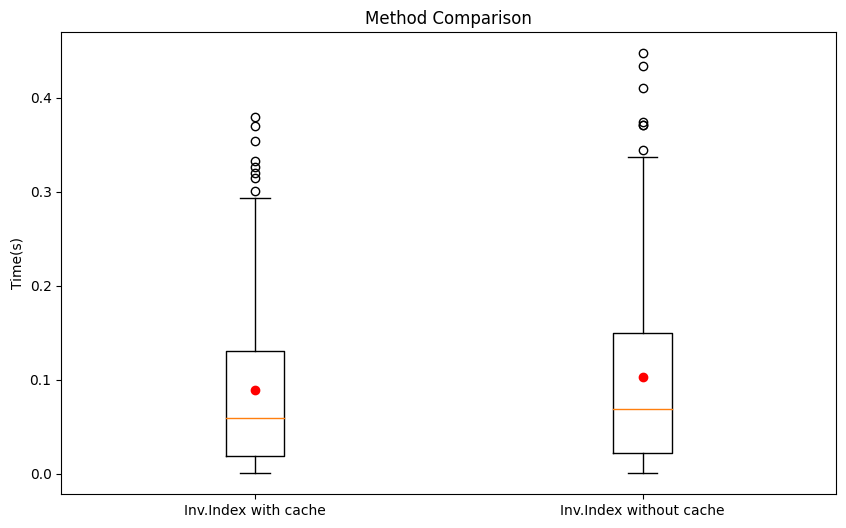

In [23]:

data = [np.sort(resCACHE[1]),np.sort(resREGULAR[1])]
means = [np.mean(d) for d in data]

# Define the percentage of outliers to ignore
top_percentage = 1  # Ignore top 1%
bottom_percentage = 0  # (Optional) Ignore bottom 0%

# Calculate the indices to cut off
n = len(data[0])
top_cutoff = int(n * (1 - top_percentage / 100))  # Index for the top cutoff
bottom_cutoff = int(n * (bottom_percentage / 100))  # Index for the bottom cutoff

data = [data[0][bottom_cutoff:top_cutoff],data[1][bottom_cutoff:top_cutoff]]


plt.figure(figsize=(10, 6))
plt.boxplot(data,vert=True)
plt.scatter([1, 2], means, color='red', label='Mean', zorder=3)
plt.title("Method Comparison")
plt.ylabel("Time(s)")
plt.xticks([1, 2], ['Inv.Index with cache', 'Inv.Index without cache'])
plt.show()


As we can see, performance is slightly better on the cache version of the index, but it's not a really meaningful improvement. However, with bigger query datasets, even a small increase in the average processing time of a single query can lead to much higher total processing time.

## Parallel query processing

To move on to bigger query datasets, it was necessary to parallelize the query processing algorithm. What follows is our implementation.

In [24]:
# Define a global variable to store the inverted index
invRegular = None  # This will be initialized globally
invCache = None
invRegular = InvertedIndexCache(lexicon, inv, doc_index, stats, False)
invCache = InvertedIndexCache(lexicon, inv, doc_index, stats, True, 10000)

def process_query(cache, q, fn):
    """Process a single query using the global inverted index."""
    try:
        # Process query using the global inv object (read-only)
        inve = globals()[cache]
        
        st = time.time()
        
        query = final_preprocess(q.text)
        queryArg = tuple(query)
    
        termids = inve.get_termids(queryArg)
        if termids:
            filtered = [(x, y) for x, y in zip(termids, query) if x != -1]
        else:
            filtered = []
    
        if filtered:
            termids, query = zip(*filtered)
            termids = list(termids)
            query = list(query)
        else:
            termids = []
            query = []
    
        postings = inve.get_postings(termids)
        if len(postings) != len(query): #Sanity check
            print(f"Discrepancy detected: query {query}")
            print(f"Term IDs: {termids}")
            print(f"Postings: {postings}")
    
        result = (q.query_id, fn(postings, query, inve))
        en = time.time()
        elapsed_time = en - st
        return result, elapsed_time
    except Exception as e:
        traceback.print_exc()
        print(e)

@profile
def query_processing_parallel(cache, queries_iter, fn, max_processes=4):
    """Parallel query processing with progress monitoring using ProcessPoolExecutor."""
    '''max_processes was set to 4 because that is the maximum number of CPU cores that Kaggle let us use'''
    '''The arg cache lets us specify which inverted index we want to use (with or without cache)
        fn represents the processing and scoring algorithms'''
    res = []
    timesOfQueries = []
    with ProcessPoolExecutor(max_processes) as executor:
        queries = list(queries_iter)

        futures = [
            executor.submit(process_query, cache, q, fn) for q in queries
        ]

        for future in tqdm(futures, desc="Processing Queries"):
            result, elapsed_time = future.result()
            res.append(result)
            timesOfQueries.append(elapsed_time)
            

    return res, timesOfQueries


Let's try parallel query processing by using a bigger dataset for queries: "antique/train".

In [25]:
dataset = ir_datasets.load("antique/train")

In [26]:

start = time.time()
resPARA, qe2 = query_processing_parallel("invCache", dataset.queries_iter(), taatTFIDF)
end = time.time()
print("Time taken: "+str(end-start))
start = time.time()
print()
print("starting regular...")
print()
resNORMAL , we = query_processing(inv_index_regular,dataset.queries_iter(), taatTFIDF)
end = time.time()
print("Time taken: "+str(end-start))


[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-train-queries.txt
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-train-queries.txt: [00:00] [137kB] [212kB/s]
Processing Queries: 100%|██████████| 2426/2426 [01:37<00:00, 24.83it/s]                         


Time taken: 99.42481637001038

starting regular...



Processing...: 100%|██████████| 2426/2426 [03:57<00:00, 10.20it/s]

Time taken: 237.80407977104187


As we can see, there is a huge jump in performance.

First off, let's test TAAT vs DAAT time-wise. 

In [27]:
resDAAT, toqDAAT = query_processing_parallel("invCache",dataset.queries_iter(), daatTFIDF)
resDAATBM, toqDAATBM = query_processing_parallel("invCache",dataset.queries_iter(), daatBM25)
resTAATBM, toqTAATBM = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25)
resTAAT, toqTAAT = query_processing_parallel("invCache",dataset.queries_iter(), taatTFIDF)

Processing Queries: 100%|██████████| 2426/2426 [01:38<00:00, 24.67it/s]


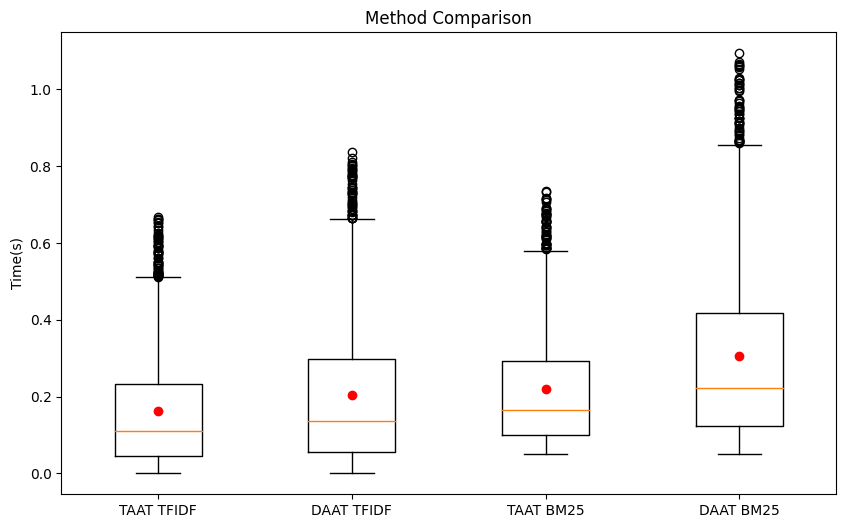

In [28]:

data = [np.sort(resTAAT[1]),np.sort(resDAAT[1]),np.sort(resTAATBM[1]),np.sort(resDAATBM[1])]
means = [np.mean(d) for d in data]

# Define the percentage of outliers to ignore
top_percentage = 1  # Ignore top 1%
bottom_percentage = 0  # (Optional) Ignore bottom 0%

# Calculate the indices to cut off
n = len(data[0])
top_cutoff = int(n * (1 - top_percentage / 100))  # Index for the top cutoff
bottom_cutoff = int(n * (bottom_percentage / 100))  # Index for the bottom cutoff

data = [data[0][bottom_cutoff:top_cutoff],data[1][bottom_cutoff:top_cutoff],data[2][bottom_cutoff:top_cutoff],data[3][bottom_cutoff:top_cutoff]]

plt.figure(figsize=(10, 6))
plt.boxplot(data,vert=True)
plt.scatter([1, 2,3,4], means, color='red', label='Mean', zorder=3)
plt.title("Method Comparison")
plt.ylabel("Time(s)")
plt.xticks([1, 2,3,4], ['TAAT TFIDF', 'DAAT TFIDF','TAAT BM25','DAAT BM25'])
plt.show()


As we can see, the average is pretty similar time-wise, but as we said before, on a very large query dataset even a small increase in average can lead to much higher processing times differences.

---
## Further analysis on caching
The reason why the cache on postings and term IDs recovery isn't particularly effective is because the most expensive operation in query processing is actually iterating through the posting lists to calculate the score. If we were to cache the results of the score calculation for a particular query, we would expect to see a major improvement in time of execution.

Let's verify this with the implementation of such a cache, as seen below.

Since each process has its own memory, we need to create our own shared cache. It will be managed in a process-safe way by the class Manager().

In [29]:
CACHE = {}
    
def taatTFIDF_Cache(shared_cache, postings, terms, inverted_index, k=30):
    for posting in postings:
        posting.reset()
    # Create a unique cache key for the combination of terms and postings
    term_ids = tuple(sorted(terms))  # A stable, hashable version of terms for the cache
    postings_ids = tuple(posting.docid() for posting in postings)  # Tuple of document IDs for the cache
    
    cache_key = (term_ids, postings_ids)  # Combined cache key
    
    # Check if the result is already cached (in memory)
    if cache_key in shared_cache:
        return shared_cache[cache_key]
    A = defaultdict(float)
    
    for posting, term in zip(postings, terms):
        posting.reset()
        
        # Get cached IDF value
        df = inverted_index.lexicon[term][1]
        idf = math.log(inverted_index.num_docs() / (df),10)
        current_docid = posting.docid()
        
        while current_docid != math.inf:
            current_docno = posting.docno()
            A[current_docno] += (1 + math.log(posting.get_freq(),10)) * idf
            posting.next()
            current_docid = posting.docid()
    # Rank documents based on their scores
    top = TopQueue(k)
    for docno, score in A.items():
        top.insert(docno, score)
    
    # Sort the results
    results = sorted(top.queue, reverse=True)
    for posting in postings:
        posting.reset()
    # Cache the results for this specific query
    shared_cache[cache_key] = results
    
    return results

def process_query_CACHE(shared_cache, cache, q, fn):
    """Process a single query using the global inverted index."""
    
    inve = globals()[cache]
    
    st = time.time()

    # Process query using the global inv object (read-only)
    query = final_preprocess(q.text)
    queryArg = tuple(query)

    termids = inve.get_termids(queryArg)
    if termids:
        filtered = [(x, y) for x, y in zip(termids, query) if x != -1]
    else:
        filtered = []

    if filtered:
        termids, query = zip(*filtered)
        termids = list(termids)
        query = list(query)
    else:
        termids = []
        query = []

    postings = inve.get_postings(termids)
    #postings = tuple(postings)
    if len(postings) != len(query):
        print(f"Discrepancy detected: query {query}")
        print(f"Term IDs: {termids}")
        print(f"Postings: {postings}")

    result = (q.query_id, fn(shared_cache, postings, query, inve))
    en = time.time()
    elapsed_time = en - st
    return result, elapsed_time

@profile
def query_processing_parallel_CACHE(cache, queries_iter, fn, max_processes=4):
    """Parallel query processing with progress monitoring using ProcessPoolExecutor."""
    
    res = []
    timesOfQueries = []
    global CACHE

    with Manager() as manager:
        shared_cache = manager.dict()
        shared_cache.update(CACHE)  # Populate after creation
        with ProcessPoolExecutor(max_processes) as executor:
            queries = list(queries_iter)
    
            futures = [
                executor.submit(process_query_CACHE, shared_cache, cache, q, fn) for q in queries
            ]
    
            for future in tqdm(futures, desc="Processing Queries"):
                result, elapsed_time = future.result()
                res.append(result)
                timesOfQueries.append(elapsed_time)
        CACHE = dict(shared_cache) #update global cache after processing all queries
    return res, timesOfQueries

In [30]:

resFIRST, toqFIRST = query_processing_parallel_CACHE("invCache",dataset.queries_iter(), taatTFIDF_Cache)
resSECOND, toqSECOND = query_processing_parallel_CACHE("invCache",dataset.queries_iter(), taatTFIDF_Cache)
print(f"Size of CACHE: {sys.getsizeof(CACHE)} bytes")

Processing Queries: 100%|██████████| 2426/2426 [00:07<00:00, 320.32it/s]


Size of CACHE: 73816 bytes


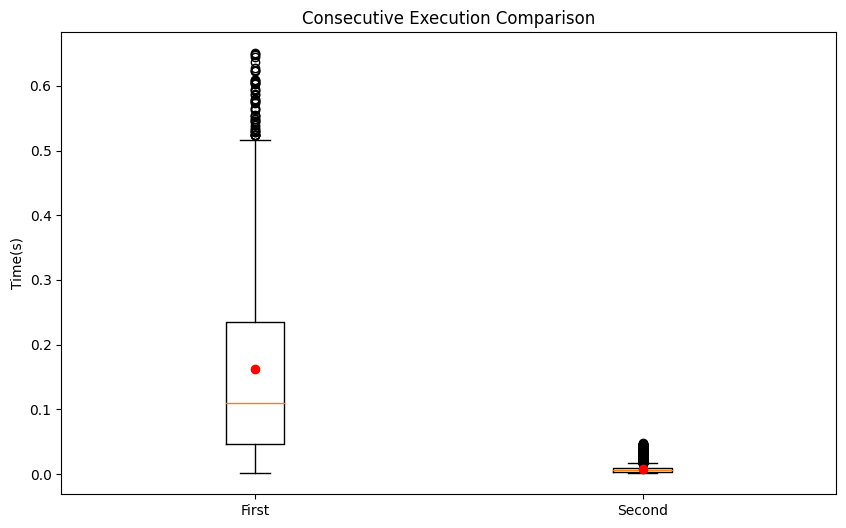

In [31]:

data = [np.sort(resFIRST[1]),np.sort(resSECOND[1])]
means = [np.mean(d) for d in data]

# Define the percentage of outliers to ignore
top_percentage = 1  # Ignore top 5%
bottom_percentage = 0  # (Optional) Ignore bottom 0%

# Calculate the indices to cut off
n = len(data[0])
top_cutoff = int(n * (1 - top_percentage / 100))  # Index for the top cutoff
bottom_cutoff = int(n * (bottom_percentage / 100))  # Index for the bottom cutoff

data = [data[0][bottom_cutoff:top_cutoff],data[1][bottom_cutoff:top_cutoff]]

plt.figure(figsize=(10, 6))
plt.boxplot(data,vert=True)
plt.scatter([1, 2], means, color='red', label='Mean', zorder=3)
plt.title("Consecutive Execution Comparison")
plt.ylabel("Time(s)")
plt.xticks([1, 2], ['First', 'Second'])
plt.show()


As we can see this is infact the case. This is because the most computationally expensive part of query processing is iterating through every posting lists to compute the score. By caching the results for a given query, we skip the calculation and we immediately obtain the score. This could be useful in IR systems where there are few queries that are requested most of the time.



Let's now compare TF-IDF and BM25 performance, starting with TF-IDF. We will be using trec-eval.

In [16]:
def generate_trec_eval_run(results, run_tag="my_run", output_file="trec_run.txt"):
    """
    Generates a TREC-formatted run file for use with trec_eval.
    
    Args:
        queries (dict): A dictionary where keys are query IDs and values are query strings.
        inverted_index (dict): The inverted index.
        document_lengths (dict): A dictionary mapping doc_ids to their lengths.
        total_documents (int): The total number of documents in the corpus.
        run_tag (str): The tag for the run.
        output_file (str): The file where the TREC run will be saved.
    """
    # Open the output file
    with open(output_file, "w") as f:
        query_id = 1        
        for query in results[0]:
            #print(query)
            rank = 0
            qid = query[0]
            for elem in query[1]:
                f.write(f"{qid} Q0 {elem[1]} {rank} {elem[0]:.4f} {run_tag}\n")
                rank +=1
            query_id+=1
    print(f"TREC run file saved as: {output_file}")

In [33]:
generate_trec_eval_run(resFIRST, run_tag="my_run", output_file="trec_run.txt")

TREC run file saved as: trec_run.txt


In [17]:
!wget 'https://github.com/usnistgov/trec_eval/archive/v9.0.8.tar.gz'
!tar zxvf 'v9.0.8.tar.gz'
!rm -rf v9.0.8.tar.gz
!make -C trec_eval-9.0.8/
!cp trec_eval-9.0.8/trec_eval .

--2025-01-19 21:00:20--  https://github.com/usnistgov/trec_eval/archive/v9.0.8.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/usnistgov/trec_eval/tar.gz/refs/tags/v9.0.8 [following]
--2025-01-19 21:00:20--  https://codeload.github.com/usnistgov/trec_eval/tar.gz/refs/tags/v9.0.8
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189343 (185K) [application/x-gzip]
Saving to: ‘v9.0.8.tar.gz’

v9.0.8.tar.gz       100%[===================>] 184.91K  --.-KB/s    in 0.02s   

2025-01-19 21:00:21 (7.84 MB/s) - ‘v9.0.8.tar.gz’ saved [189343/189343]

trec_eval-9.0.8/
trec_eval-9.0.8/.github/
trec_eval-9.0.8/.github/workflows/
trec_eval-9.0.8/.github/workflows/push.yml
tre

In [18]:
import ir_datasets

# Save qrels to a file
qrels_file = "qrels.txt"
with open(qrels_file, "w") as f:
    for qrel in dataset.qrels_iter():
        f.write(f"{qrel.query_id} 0 {qrel.doc_id} {qrel.relevance}\n")
print(f"Qrels saved to {qrels_file}")


[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-train.qrel
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-train.qrel: [00:00] [626kB] [1.57MB/s]
                                                                                          

Qrels saved to qrels.txt


The argument -l3 makes it so trec_eval will only consider relevant the documents with relevance assessment 3 or higher.

In [36]:
!./trec_eval -l3 qrels.txt trec_run.txt
!./trec_eval -m ndcg_cut.10 qrels.txt trec_run.txt

runid                 	all	my_run
num_q                 	all	2412
num_ret               	all	71529
num_rel               	all	19732
num_rel_ret           	all	3592
map                   	all	0.1028
gm_map                	all	0.0027
Rprec                 	all	0.1187
bpref                 	all	0.2066
recip_rank            	all	0.3175
iprec_at_recall_0.00  	all	0.3279
iprec_at_recall_0.10  	all	0.2908
iprec_at_recall_0.20  	all	0.2091
iprec_at_recall_0.30  	all	0.1385
iprec_at_recall_0.40  	all	0.0998
iprec_at_recall_0.50  	all	0.0789
iprec_at_recall_0.60  	all	0.0437
iprec_at_recall_0.70  	all	0.0337
iprec_at_recall_0.80  	all	0.0197
iprec_at_recall_0.90  	all	0.0156
iprec_at_recall_1.00  	all	0.0152
P_5                   	all	0.1361
P_10                  	all	0.0959
P_15                  	all	0.0756
P_20                  	all	0.0633
P_30                  	all	0.0496
P_100                 	all	0.0149
P_200                 	all	0.0074
P_500                 	all	0.0030
P_1000              

TF-IDF's performance is not very impressive, but this does not surprise us. Let's look first-hand at some of the documents that were relevant for a query and at some of the documents that we retrieved. Just as an example, we chose query 3958139.

In [37]:
doc_dict = {doc.doc_id: doc.text for doc in dataset.docs_iter()}
queries_dict = {query.query_id: query.text for query in dataset.queries_iter()}

In [38]:
qrelfile = open('qrels.txt')
runfile = open('trec_run.txt')
lines = qrelfile.readlines()
quid = '3958139'
relevantDocs = []
print(f"This is query {quid}: "+str(queries_dict[quid]))
print()
for line in lines:
    if (line.split()[0] == quid and int(line.split()[3]) >= 3):
        relevantDocs.append(line.split()[2])
print(f"These are the relevant docs for query {quid}: "+str(relevantDocs))

print()
retrievedDocs = []
lines = runfile.readlines()
for line in lines:
    if line.split()[0] == quid:
        retrievedDocs.append(line.split()[2])
print(f"These are the retrieved docs for query {quid}: "+str(retrievedDocs))
rr = 0
for doc in relevantDocs:
    if doc in retrievedDocs:
        rr+=1
print()
print("Matching: "+str(rr))
print()
i = 0
print("THESE ARE SOME OF THE RELEVANT DOCUMENTS: ")
for doc in relevantDocs:
    print(doc_dict[doc])
    print()
    i+=1
    if i == 11:
        break
print()
print("THESE ARE THE TOP 10 RETRIEVED DOCUMENTS:")
print()
i = 0

for doc in retrievedDocs:
    print(doc_dict[doc])
    print()
    i+=1
    if i == 11:
        break

This is query 3958139: Why are atheists mostly depressed?

These are the relevant docs for query 3958139: ['3958139_8', '3958139_1', '3958139_3', '3958139_5', '3958139_9', '3958139_10', '3958139_11', '3958139_16', '3958139_17', '3958139_14', '3958139_15', '3958139_19']

These are the retrieved docs for query 3958139: ['3958139_16', '582847_16', '4083387_3', '2210132_16', '3958139_4', '3958139_15', '2693196_6', '1377276_11', '1125162_4', '2471546_7', '563082_16', '462620_0', '3516047_3', '32128_24', '971813_3', '1326167_7', '3844456_4', '4000253_12', '3958139_9', '3958139_19', '3958139_17', '3958139_12', '92934_15', '3280768_20', '2606456_0', '2210132_10', '1402622_17', '2990754_3', '1446860_10', '4081083_6']

Matching: 5

THESE ARE SOME OF THE RELEVANT DOCUMENTS: 
Because they are whiners, maybe they should move to Napa the wine country!!!!!

I'm not depressed. I'm angry at the religious manipulation, and furious that this manipulation is also affecting those of us who have freely chos

The bias that TF-IDF has towards longer documents is evident.

Let's now test BM25.

In [39]:

resCACHE, toqCACHE = query_processing_parallel("invCache", dataset.queries_iter(), taatBM25)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_run.txt")


Processing Queries: 100%|██████████| 2426/2426 [02:14<00:00, 18.02it/s]


TREC run file saved as: trec_run.txt


In [40]:
!./trec_eval -l3 qrels.txt trec_run.txt
!./trec_eval -m ndcg_cut.10 qrels.txt trec_run.txt

runid                 	all	my_run
num_q                 	all	2412
num_ret               	all	71529
num_rel               	all	19732
num_rel_ret           	all	4207
map                   	all	0.1306
gm_map                	all	0.0048
Rprec                 	all	0.1491
bpref                 	all	0.2303
recip_rank            	all	0.3790
iprec_at_recall_0.00  	all	0.3903
iprec_at_recall_0.10  	all	0.3484
iprec_at_recall_0.20  	all	0.2635
iprec_at_recall_0.30  	all	0.1833
iprec_at_recall_0.40  	all	0.1287
iprec_at_recall_0.50  	all	0.1035
iprec_at_recall_0.60  	all	0.0599
iprec_at_recall_0.70  	all	0.0477
iprec_at_recall_0.80  	all	0.0282
iprec_at_recall_0.90  	all	0.0221
iprec_at_recall_1.00  	all	0.0216
P_5                   	all	0.1702
P_10                  	all	0.1164
P_15                  	all	0.0909
P_20                  	all	0.0764
P_30                  	all	0.0581
P_100                 	all	0.0174
P_200                 	all	0.0087
P_500                 	all	0.0035
P_1000              

As expected, BM25 performs better than TF-IDF. Can we improve further?

We thought it would be a good idea to reward documents that have a high number of unique term matches with the query. This reward is quantified by the variable coverage_weight, as shown below.

In [41]:
coverage_weight = 5

def taatBM25_coverageWeight(postings, terms, inverted_index, k=30, k1=1.2, b=0.75):
    exp = True
    A = defaultdict(float)
    term_matches = defaultdict(set)
    avg_doc_len = sum(doc_len for _, doc_len in inverted_index.doc.values())/ inverted_index.num_docs()
    for posting, term in zip(postings, terms):
        posting.reset()
        if term not in inverted_index.lexicon:
            continue

        # Get the IDF for the term using the BM25 formula
        df = inverted_index.lexicon[term][1]
        idf = math.log((inverted_index.num_docs() - df + 0.5) / (df + 0.5) + 1.0)
        current_docid = posting.docid()
        
        while current_docid != math.inf:
            # Retrieve the frequency of the term in the current document
            term_freq = posting.get_freq()

            # Document length for current document
            doc_len = inverted_index.doc[current_docid][1]

            # BM25 score for the term in the current document
            norm_factor = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * doc_len / avg_doc_len))
            score = idf * norm_factor
            current_docno = posting.docno()
            # Update the score for the current document
            A[current_docno] += score
            term_matches[current_docno].add(term)
            # Move to the next posting
            posting.next()
            current_docid = posting.docid()
            
    k = k
    # Update doc scores based on unique term matching
    for docid in term_matches:
        unique_term_coverage = len(term_matches[docid]) / len(terms)  # Fraction of query terms matched
        A[docid] += coverage_weight * unique_term_coverage
    # Rank documents based on their BM25 score
    top = TopQueue(k)
    for docno, score in A.items():
        top.insert(docno, score)
    
    # Return the top-k documents ranked by BM25 score
    return sorted(top.queue, reverse=True)



Let's try multiple values for coverage_weight and compare the results.

In [42]:
coverage_weight = 2
resCACHE, toqCACHE = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25_coverageWeight)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_run2.txt")
!./trec_eval -l3 qrels.txt trec_run2.txt > coverage2.txt
!./trec_eval -m ndcg_cut.10 -l3 qrels.txt trec_run2.txt >> coverage2.txt

Processing Queries: 100%|██████████| 2426/2426 [03:32<00:00, 11.44it/s]


TREC run file saved as: trec_run2.txt


In [43]:
coverage_weight = 3
resCACHE, toqCACHE = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25_coverageWeight)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_run2.txt")
!./trec_eval -l3 qrels.txt trec_run2.txt > coverage3.txt
!./trec_eval -m ndcg_cut.10 -l3 qrels.txt trec_run2.txt >> coverage3.txt

Processing Queries: 100%|██████████| 2426/2426 [03:30<00:00, 11.53it/s]


TREC run file saved as: trec_run2.txt


In [44]:
coverage_weight = 5
resCACHE, toqCACHE = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25_coverageWeight)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_runCW5.txt")
!./trec_eval -l3 qrels.txt trec_runCW5.txt > coverage5.txt
!./trec_eval -m ndcg_cut.10 -l3 qrels.txt trec_runCW5.txt >> coverage5.txt

Processing Queries: 100%|██████████| 2426/2426 [03:28<00:00, 11.65it/s]


TREC run file saved as: trec_runCW5.txt


In [45]:

coverage_weight = 10
resCACHE, toqCACHE = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25_coverageWeight)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_run.txt")
!./trec_eval -l3 qrels.txt trec_run.txt > coverage10.txt
!./trec_eval -m ndcg_cut.10 qrels.txt trec_run.txt >> coverage10.txt


Processing Queries: 100%|██████████| 2426/2426 [03:28<00:00, 11.63it/s]


TREC run file saved as: trec_run.txt


In [46]:

coverage_weight = 15
resCACHE, toqCACHE = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25_coverageWeight)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_run.txt")
!./trec_eval -l3 qrels.txt trec_run.txt > coverage15.txt
!./trec_eval -m ndcg_cut.10 qrels.txt trec_run.txt >> coverage15.txt


Processing Queries: 100%|██████████| 2426/2426 [03:28<00:00, 11.64it/s]


TREC run file saved as: trec_run.txt


In [47]:
coverage_weight = 20
resCACHE, toqCACHE = query_processing_parallel("invCache",dataset.queries_iter(), taatBM25_coverageWeight)
generate_trec_eval_run(resCACHE, run_tag="my_run", output_file="trec_run.txt")
!./trec_eval -l3 qrels.txt trec_run.txt > coverage20.txt
!./trec_eval -m ndcg_cut.10 qrels.txt trec_run.txt >> coverage20.txt

Processing Queries: 100%|██████████| 2426/2426 [03:32<00:00, 11.39it/s]


TREC run file saved as: trec_run.txt


In [48]:
cov2 = open("coverage2.txt")
cov3 = open("coverage3.txt")
cov5 = open("coverage5.txt")
cov10 = open("coverage10.txt")
cov15 = open("coverage15.txt")
cov20 = open("coverage20.txt")
files = []
files.append(cov2)
files.append(cov3)
files.append(cov5)
files.append(cov10)
files.append(cov15)
files.append(cov20)
metrics = {}
for f in files:
    metrics[f.name] = {}
    for line in f:
        parts = line.split()  # Split line into columns
        if len(parts) == 3:   # Ensure the line has the expected format
            metric, query_id, value = parts
            if query_id == "all":  # Focus on overall metrics
                metrics[f.name][metric] = value

[4251, 4263, 4282, 4274, 4267, 4247]


Text(0.5, 0, 'Coverage Weight')

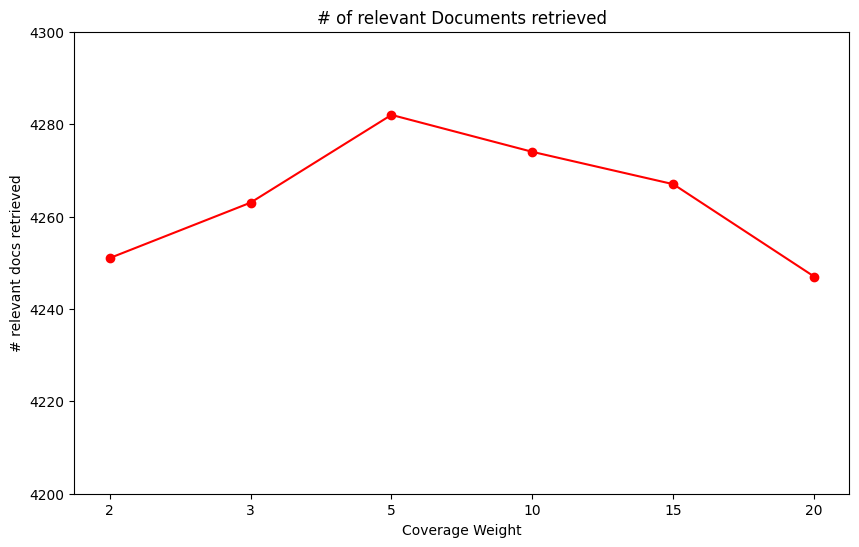

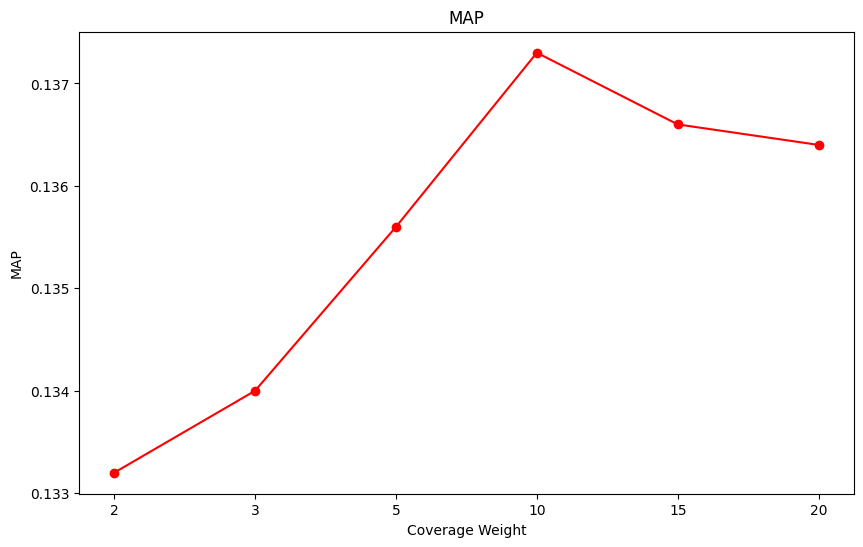

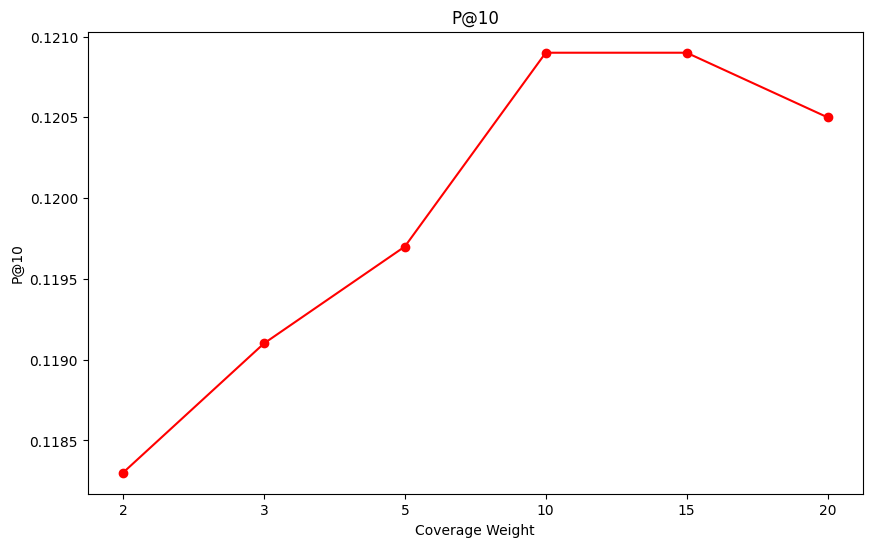

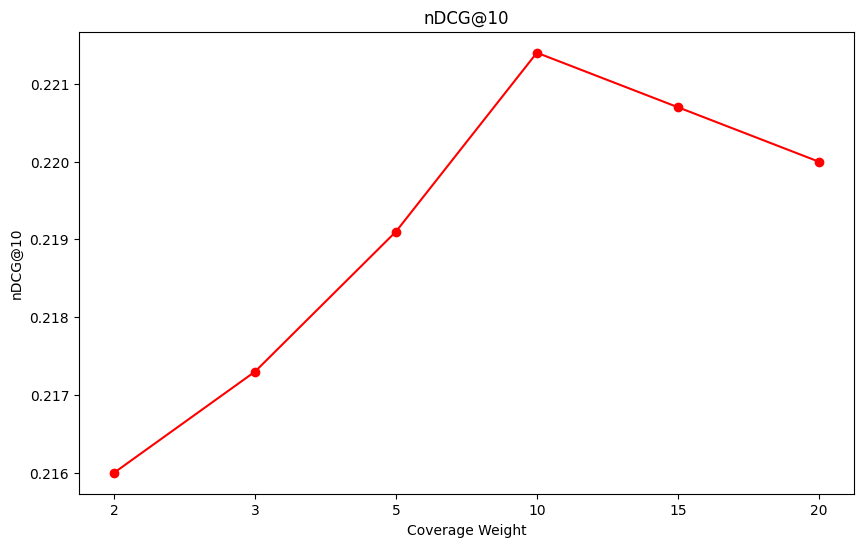

In [49]:
numRel = []
MAP = []
PAT10 = []
nDCGAT10 = []
cat = ['2','3','5','10','15', '20']
for k in metrics.keys():
    numRel.append(int(metrics[k]["num_rel_ret"]))
    MAP.append(float(metrics[k]["map"]))
    PAT10.append(float(metrics[k]["P_10"]))
    nDCGAT10.append(float(metrics[k]["ndcg_cut_10"]))
print(numRel)
plt.figure(figsize =(10,6))
plt.title("# of relevant Documents retrieved")
plt.plot(cat, numRel, marker='o', linestyle='-', color='red', label='Values')
plt.ylabel("# relevant docs retrieved")
plt.xlabel("Coverage Weight")
plt.ylim(4200,4300)
plt.figure(figsize =(10,6))
plt.title("MAP")
plt.plot(cat, MAP, marker='o', linestyle='-', color='red', label='Values')
plt.ylabel("MAP")
plt.xlabel("Coverage Weight")
plt.figure(figsize =(10,6))
plt.title("P@10")
plt.plot(cat, PAT10, marker='o', linestyle='-', color='red', label='Values')
plt.ylabel("P@10")
plt.xlabel("Coverage Weight")
plt.figure(figsize =(10,6))
plt.title("nDCG@10")
plt.plot(cat, nDCGAT10, marker='o', linestyle='-', color='red', label='Values')
plt.ylabel("nDCG@10")
plt.xlabel("Coverage Weight")
#plt.xticks([1, 2, 3, 4], ['2', '3', '5','10'])

The maximum number of documents retrieved is obtained for CW = 5, however the other statistics are better for CW = 10. 

Again, let's look first-hand at some of the documents that were relevant for a query and at some of the documents that we retrieved. As an example, we will look at query 4022485.

In [50]:
doc_dict = {doc.doc_id: doc.text for doc in dataset.docs_iter()}
queries_dict = {query.query_id: query.text for query in dataset.queries_iter()}

In [51]:
qrelfile = open('qrels.txt')
runfile = open('trec_run2.txt')
lines = qrelfile.readlines()
quid = '4022485'
relevantDocs = []
print(f"This is query {quid}: "+str(queries_dict[quid]))
print()
for line in lines:
    if (line.split()[0] == quid and int(line.split()[3]) >= 3):
        relevantDocs.append(line.split()[2])
print(f"These are the relevant docs for query {quid}: "+str(relevantDocs))

print()
retrievedDocs = []
lines = runfile.readlines()
for line in lines:
    if line.split()[0] == quid:
        retrievedDocs.append(line.split()[2])
print(f"These are the retrieved docs for query {quid}: "+str(retrievedDocs))
rr = 0
for doc in relevantDocs:
    if doc in retrievedDocs:
        rr+=1
print()
print("Matching: "+str(rr))
print()
i = 0
print("THESE ARE SOME OF THE RELEVANT DOCUMENTS: ")
for doc in relevantDocs:
    print(doc_dict[doc])
    print()
    i+=1
    if i == 11:
        break
print()
print("THESE ARE THE TOP 10 RETRIEVED DOCUMENTS:")
print()
i = 0

for doc in retrievedDocs:
    print(doc_dict[doc])
    print()
    i+=1
    if i == 11:
        break

This is query 4022485: Why does a person need to be humble?

These are the relevant docs for query 4022485: ['4022485_2', '4022485_20', '4022485_21', '4022485_19', '4022485_14', '4022485_17', '4022485_16', '4022485_11', '4022485_10', '4022485_13', '4022485_12', '4022485_5', '4022485_4', '4022485_7', '4022485_6', '4022485_1', '4022485_0', '4022485_3', '4022485_9', '4022485_8']

These are the retrieved docs for query 4022485: ['4194493_0', '2055736_1', '3389038_1', '4022485_9', '4022485_12', '639062_0', '3030581_3', '4022485_1', '262748_6', '2048800_0', '416787_14', '1675822_0', '83371_11', '2500804_4', '4022485_11', '2370485_3', '746268_2', '1898102_2', '2938839_4', '2902830_4', '4022485_0', '4022485_4', '3095907_5', '2938839_7', '2731310_2', '804166_2', '3420893_4', '2370485_13', '181119_409', '2370485_5']

Matching: 6

THESE ARE SOME OF THE RELEVANT DOCUMENTS: 
You do not need to be humble,this is a ploy by weak minded people to get motivated people to stop making them look bad.The wo

As we can see, the top 10 documents we retrieved are all about the word 'humble', however some of them are clearly out of the question's context. 

This in fact one of BM25's biggest weaknesses: the inability to understand and represent the true meaning of a query.

## Pyterrier 

We wanted to see how our IR system compared to the standard BM25 retriever offered by PyTerrier.

In [52]:
import pyterrier as pt
#pt.init()
dataset2 = ir_datasets.load("antique/train")
# Convert to PyTerrier format
docs = pd.DataFrame(dataset2.docs_iter()).rename(columns={'doc_id': 'docno', 'text': 'text'})
queries = pd.DataFrame(dataset2.queries_iter()).rename(columns={'query_id': 'qid', 'text': 'query'})
qrels_og = pd.DataFrame(dataset2.qrels_iter()).rename(columns={'query_id': 'qid', 'doc_id': 'docno', 'relevance': 'label'})

# Filter for highly relevant documents (level 3 or higher)
qrels = qrels_og[qrels_og["label"] >= 3]


import re

def clean_query(query):
    """
    Clean a query by removing problematic characters.
    Retains only alphanumeric characters and spaces.
    This method was necessary since we were receiving errors for some queries.
    """
    # Remove all non-alphanumeric characters except spaces
    return re.sub(r'[^\w\s]', '', query).strip()

# Clean all queries in advance
queries['query'] = queries['query'].apply(clean_query)

# Create an index
indexer = pt.IterDictIndexer("./antique_index")
docs_iterable = docs.to_dict(orient="records")  # Convert to a list of dictionaries
index_ref = indexer.index(docs_iterable)




terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


10:00:06.271 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (730691_1) - further warnings are suppressed
10:00:42.606 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 2224 empty documents


In [53]:
print("start retrieve...")
# Retrieve with BM25
retriever = pt.terrier.Retriever(index_ref, wmodel="BM25")
results = retriever.transform(queries)
# Evaluate results
print("These are the statistical results for PyTerrier's retriever:")
eval_metrics = pt.Evaluate(results, qrels, metrics=[AP, RR, nDCG@10, P@5, P@10])
print(eval_metrics)

start retrieve...
These are the statistical results for PyTerrier's retriever:
{'AP': 0.13686681271121262, 'RR': 0.3685939210131917, 'nDCG@10': 0.19752405227387745, 'P@5': 0.16710634789777212, 'P@10': 0.11463314097279415}


Every value is roughly similar to our basic version of BM25, which is a good sign that our implementation is correct.

## Major weakness: Misspellings

During our testing, we noticed that our algorithms retrieved few or no documents for some queries. We decided to analyze why this was happening. 

In [54]:
queries_dict = {query.query_id: query.text for query in dataset.queries_iter()}
qIDs = []

j = 0
for i in resCACHE[0]:
    if (len(i[1])) < 10:
        print(f"For query {resCACHE[0][j][0]} we retrieved {len(i[1])} documents")
        qIDs.append(resCACHE[0][j][0])
        print()
    j+=1


For query 4359052 we retrieved 3 documents

For query 1803954 we retrieved 3 documents

For query 1476791 we retrieved 1 documents

For query 911954 we retrieved 1 documents

For query 3415459 we retrieved 0 documents

For query 1639607 we retrieved 2 documents

For query 4127969 we retrieved 0 documents

For query 4338583 we retrieved 0 documents

For query 2468788 we retrieved 5 documents

For query 1749225 we retrieved 1 documents

For query 3536922 we retrieved 3 documents

For query 3629548 we retrieved 5 documents

For query 2539683 we retrieved 0 documents

For query 2207146 we retrieved 6 documents

For query 459726 we retrieved 0 documents

For query 2913866 we retrieved 0 documents

For query 4409 we retrieved 0 documents

For query 4087556 we retrieved 3 documents

For query 3280274 we retrieved 7 documents

For query 828917 we retrieved 7 documents

For query 2961191 we retrieved 6 documents

For query 1163367 we retrieved 1 documents

For query 4449648 we retrieved 2 docum

Let's look at some of those queries:

In [55]:
words = []
for q in qIDs:
    print(q)
    print(queries_dict[q])
    words.append(queries_dict[q])
    print()

4359052
What is an Allantois?

1803954
what is a dugan?

1476791
what is 7-(34x5)-20+400-82+290= ?

911954
what is intrapreneurship?

3415459
Why are they so negtive?

1639607
what is a diruetic?

4127969
what is a talipia?

4338583
how is it being you?

2468788
What is Pantheism?

1749225
What is anatidaephobia?

3536922
what is tautomerism?

3629548
What is philately?

2539683
what is cocciclusters?

2207146
What is "showerhead"?

459726
what is endometriousus?

2913866
what is 15cc?

4409
what is avyohya?

4087556
what is "nippon"?

3280274
What is a schnitzel?

828917
what is a milner?

2961191
What is Ogopogo?

1163367
is there a starting(origin) of the earth....if there ,,,then why it is started...how it is started..tell me?

4449648
what is a huffler?

332662
what is sosiology?

3231140
what is a mandula oblongata?

1121034
What if the hokie pokie IS what it's all about =)?

4282000
Why does my Caprice......?

1530148
what is persepolis?

923913
what is a synonyom?

52981
what a

In [56]:
wordsToCheck = []
for w in words:
    temp = final_preprocess(w)
    for t in temp:
        wordsToCheck.append(t)
for w in wordsToCheck:
    if w in lexicon:
        print(f"{w} is in the lexicon")
    else:
        print(f"{w} is NOT in the lexicon")
    print()

allantoi is in the lexicon

dugan is in the lexicon

734x52040082290 is in the lexicon

intrapreneurship is in the lexicon

negtiv is NOT in the lexicon

diruet is in the lexicon

talipia is NOT in the lexicon

pantheism is in the lexicon

anatidaephobia is in the lexicon

tautomer is in the lexicon

philat is in the lexicon

cocciclust is NOT in the lexicon

showerhead is in the lexicon

endometriousu is NOT in the lexicon

15cc is NOT in the lexicon

avyohya is NOT in the lexicon

nippon is in the lexicon

schnitzel is in the lexicon

milner is in the lexicon

ogopogo is in the lexicon

startingorigin is NOT in the lexicon

earthif is in the lexicon

startedhow is NOT in the lexicon

startedtel is NOT in the lexicon

huffler is in the lexicon

sosiolog is NOT in the lexicon

mandula is NOT in the lexicon

oblongata is in the lexicon

hoki is in the lexicon

poki is in the lexicon

capric is in the lexicon

persepoli is in the lexicon

synonyom is in the lexicon

tempon is NOT in the 

As we can see, a lot of queries contain misspellings. One contains a very specific mathematical operation, while another ('how is it being you?') contains exclusively words that are considered stop words by Wordnet. The rest simply contain very rare words that appear in very few documents.

In regards to the misspellings, if any documents were found, it is only because they happened to contain the same misspelling, but in reality there were probably more documents that would've been relevant had the word been spelled correctly. Let's confirm this with 'chormosomes'.

In [57]:
bla = final_preprocess('chormosomes')[0]
print(f"Lexicon entry of '{bla}': \n Document frequency: {lexicon[bla][1]}\n Term frequency: {lexicon[bla][2]}")
bla = final_preprocess('chromosomes')[0]
print(f"Lexicon entry of '{bla}': \n Document frequency: {lexicon[bla][1]}\n Term frequency: {lexicon[bla][2]}")

Lexicon entry of 'chormosom': 
 Document frequency: 1
 Term frequency: 1
Lexicon entry of 'chromosom': 
 Document frequency: 220
 Term frequency: 402


This is yet another weakness of the BM25 and more in general of the bag-of-words models: "chormosomes" is represented in a different entry of the lexicon and treated completely independently with respect to "chromosomes".

A further development of this project could be to account for misspellings, for example by looking at neighboring words (meaning that they differ only by a few letters) in case the document frequency is extremely low.

## Relevance feedback algorithm using qrels

As a further improvement, we decided to implement our own relevance feedback algorithm, inspired by the Rocchio algorithm. The goal of the algorithm is to add new terms to the query based on which documents were relevant and which were not, based on the previous results of query processing.

The feedback will be provided by the qrels: we will consider relevant every document we retrieved that matches an entry in the qrel file with relevance assessment 3 or higher.

First of all we need a direct index that maps a doc ID and a term to the relative frequency.

In [19]:
def delta_decode(encoded_list):
    original_docids = []
    current_id = 0
    for delta in encoded_list:
        current_id += delta
        original_docids.append(current_id)
    return original_docids

directIndex = {}

for key in lexicon.keys(): 
    compressed_docids = inv['docids'][lexicon[key][0]].tolist()
    compressed_freqs = inv['freqs'][lexicon[key][0]].tolist()
    decoded_docids = VBDecode(compressed_docids)
    decoded_freqs = VBDecode(compressed_freqs)
    decoded_docids = delta_decode(decoded_docids)
    for i in range(0,len(decoded_docids)):
        if not isinstance(directIndex.get(decoded_docids[i]), dict):
            directIndex[decoded_docids[i]] = {}
        directIndex[decoded_docids[i]][key] = decoded_freqs[i]


What follows is the function used to update query term weight. 

β and γ were divided by the total number of relevant and irrelevant documents, respectively. By dividing by the number of relevant/irrelevant documents, we normalize the effect of feedback across queries with different numbers of relevant/irrelevant documents. This keeps the adjustment balanced regardless of whether we have, say, 5 or 50 relevant/irrelevant documents.

In [20]:
def rocchio_update(terms, relevant_docs, non_relevant_docs, inverted_index, alpha=4.0, beta=8.00, gamma=4):
    """
    Update query term weights using Rocchio-inspired feedback, adding terms from relevant documents.
    """
    updated_query_weights = defaultdict(float)
    avg_doc_len = sum(doc_len for _, doc_len in inverted_index.doc.values()) / inverted_index.num_docs()
    
    # Weights for terms in the initial query
    for term in terms:
        if term in inverted_index.lexicon:
            updated_query_weights[term] += alpha  
    
    # Adjust weights based on relevant documents
    for docid in relevant_docs:
        for term in directIndex[docid]:  # All terms in the relevant document
            term_freq = directIndex[docid][term]
            if term_freq <= 2: #We are ignoring terms with very low frequency
                continue
            termID = inverted_index.lexicon[term][0]
            if term not in updated_query_weights:
                # Initialize the term weight if it's a new term
                updated_query_weights[term] = 0
            updated_query_weights[term] += beta / len(relevant_docs)
    
    # Subtract weights based on non-relevant documents
    for docid in non_relevant_docs:
        for term in directIndex[docid]:  # All terms in the non-relevant document
            if term in inverted_index.lexicon:
                term_freq = directIndex[docid][term]
                if term_freq <= 2: #We are ignoring terms with very low frequency
                    continue
                termID = inverted_index.lexicon[term][0]
                
                updated_query_weights[term] -= gamma / len(non_relevant_docs)
    
    # Normalize weights for new terms
    for term in updated_query_weights:
        if updated_query_weights[term] < 0:
            updated_query_weights[term] = 0  # Ensure no negative weights
    
    return updated_query_weights


Next is the first method used for score calculation, which finds initial relevant documents.

In [21]:
coverage_weight = 5

def taatBM25_coverageWeight(postings, terms, inverted_index, k=30, k1=1.2, b=0.75):
    try:
        exp = True
        A = defaultdict(float)
        D = defaultdict()
        term_matches = defaultdict(set)
        avg_doc_len = sum(doc_len for _, doc_len in inverted_index.doc.values())/ inverted_index.num_docs()
        for posting, term in zip(postings, terms):
            posting.reset()
            if term not in inverted_index.lexicon:
                continue
    
            # Get the IDF for the term using the BM25 formula
            df = inverted_index.lexicon[term][1]
            idf = math.log((inverted_index.num_docs() - df + 0.5) / (df + 0.5) + 1.0)
            current_docid = posting.docid()
            
            while current_docid != math.inf:
                # Retrieve the frequency of the term in the current document
                term_freq = posting.get_freq()
    
                # Document length for current document
                doc_len = inverted_index.doc[current_docid][1]
    
                # BM25 score for the term in the current document
                norm_factor = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * doc_len / avg_doc_len))
                score = idf * norm_factor
                current_docno = posting.docno()
                # Update the score for the current document
                A[current_docno] += score
                term_matches[current_docno].add(term)
                D[current_docno] = current_docid
                
                # Move to the next posting
                posting.next()
                current_docid = posting.docid()
                
        k = k
        for docid in term_matches:
            unique_term_coverage = len(term_matches[docid]) / len(terms)  # Fraction of query terms matched
            A[docid] += coverage_weight * unique_term_coverage
        # Rank documents based on their BM25 score
        top = TopQueue(k)
        for docno, score in A.items():
            top.insert(docno, score,D[docno])
        
        # Return the top-k documents ranked by BM25 score
        return sorted(top.queue, reverse=True)
    except Exception as e:
        print("exception in taatbm25 coverage weight, "+str(e))


The following is the method used for the calculation of the score relative to the updated query, with adjusted weights for the terms.

In [22]:
def taatBM25_with_feedback(postings, terms, inverted_index, relevant_docs, non_relevant_docs, k=30, k1=1.2, b=0.75):
    """
    Modified TAAT BM25 scoring with Rocchio-inspired relevance feedback.
    """
    try:
        D = defaultdict()
        # Update query using Rocchio-inspired feedback
        updated_query_weights = rocchio_update(terms, relevant_docs, non_relevant_docs, inverted_index)
        for term in updated_query_weights.keys():
            if term not in terms:
                terms.append(term)
        terms = tuple(terms)
        termids = inverted_index.get_termids(terms)
        postings = inverted_index.get_postings(termids)
        # Compute scores using updated query weights
        A = defaultdict(float)
        term_matches = defaultdict(set)
        avg_doc_len = sum(doc_len for _, doc_len in inverted_index.doc.values()) / inverted_index.num_docs()
        for posting, term in zip(postings, terms):
            posting.reset()
            if term not in inverted_index.lexicon:
                continue
            
            # Get updated query weight for the term
            term_weight = updated_query_weights[term]
            current_docid = posting.docid()
            
            while current_docid != math.inf:
                term_freq = posting.get_freq()
                doc_len = inverted_index.doc[current_docid][1]
                norm_factor = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * doc_len / avg_doc_len))
                idf = math.log((inverted_index.num_docs() - inverted_index.lexicon[term][1] + 0.5) /
                           (inverted_index.lexicon[term][1] + 0.5) + 1.0)
                score = term_weight * norm_factor * idf #idf is included in the term weight
                current_docno = posting.docno()
                A[current_docno] += score
                D[current_docno] = current_docid
                term_matches[current_docno].add(term)
                posting.next()
                current_docid = posting.docid()
        
        # Rank documents based on their BM25 score
        top = TopQueue(k)
        for docno, score in A.items():
            top.insert(docno, score,D[docno])
        
        return sorted(top.queue, reverse=True)
    except Exception as e:
        print(e)
        


In [23]:
# Define a global variable to store the inverted index
invRegular = None  # This will be initialized globally
invCache = None
invRegular = InvertedIndexCache(lexicon, inv, doc_index, stats, False)
invCache = InvertedIndexCache(lexicon, inv, doc_index, stats, True, 10000)


def process_query_with_update(cache, q, fn):
    """Process a single query using the global inverted index."""
    try:
        inve = globals()[cache]
        
        st = time.time()
    
        # Process query using the global inv object (read-only)
        query = final_preprocess(q.text)

        queryArg = tuple(query)
    
        termids = inve.get_termids(queryArg)
        if termids:
            filtered = [(x, y) for x, y in zip(termids, query) if x != -1]
        else:
            filtered = []
    
        if filtered:
            termids, query = zip(*filtered)
            termids = list(termids)
            query = list(query)
        else:
            termids = []
            query = []
    
        postings = inve.get_postings(termids)
        if len(postings) != len(query):
            print(f"Discrepancy detected: query {query}")
            print(f"Term IDs: {termids}")
            print(f"Postings: {postings}")
    
        Res = []
        Res = taatBM25_coverageWeight(postings, query, inve) # Obtain initial results
        for iter in range(0,1):      
            initialRes = []
            for elem in Res:
                initialRes.append(elem[1])
            
            qrelfile = open('qrels.txt')
            lines = qrelfile.readlines()
            relevantDocs = []
            qid = q.query_id
            for line in lines:
                if (line.split()[0] == qid and int(line.split()[3]) >= 3):
                    relevantDocs.append(line.split()[2])
            setRel = set(relevantDocs)
            setRes = set(initialRes)
            
            relevantFound = list(setRel & setRes) # Find which documents retrieved were actually relevant according to qrels      
            relevantFound = [elem[2] for elem in Res if elem[1] in relevantFound] 
            
            nonRelevantFound = list(setRes-setRel) #Find which documents retrieved were NOT actually relevant according to qrels
            nonRelevantFound = [elem[2] for elem in Res if elem[1] not in relevantFound] 
            
            Res = taatBM25_with_feedback(postings, query, inve, relevantFound, nonRelevantFound) # Calculate score with term weights based on relevance feedback
            
        result = (q.query_id, Res)
        en = time.time()
        elapsed_time = en - st
        return result, elapsed_time
    except Exception as e:
        print("exception in process query with update, "+str(e))

@profile
def query_processing_parallel(cache, queries_iter, fn, max_processes=4):
    """Parallel query processing with progress monitoring using ProcessPoolExecutor."""
    
    res = []
    timesOfQueries = []

    with ProcessPoolExecutor(max_processes) as executor:
        queries = list(queries_iter)

        futures = [
            executor.submit(process_query, cache, q, fn) for q in queries
        ]

        for future in tqdm(futures, desc="Processing Queries"):
            result, elapsed_time = future.result()
            res.append(result)
            timesOfQueries.append(elapsed_time)
            

    return res, timesOfQueries


@profile
def query_processing_with_update(cache, queries_iter, fn, max_processes=4):
    res = []
    timesOfQueries = []
    with ProcessPoolExecutor(max_processes) as executor:
        queries = list(queries_iter)

        futures = [
            executor.submit(process_query_with_update, cache, q, fn) for q in queries
        ]

        for future in tqdm(futures, desc="Processing Queries"):
            result, elapsed_time = future.result()
            res.append(result)
            timesOfQueries.append(elapsed_time)
            

    return res, timesOfQueries
    

In [26]:

dataset = ir_datasets.load("antique/train")
resUPDATE, toqUPDATE = query_processing_with_update("invCache",dataset.queries_iter(),taatBM25_coverageWeight)


[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-train-queries.txt
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-train-queries.txt: [00:00] [137kB] [578kB/s]
Processing Queries: 100%|██████████| 2426/2426 [16:20<00:00,  2.48it/s]                         


In [27]:
import ir_datasets

# Save qrels to a file
qrels_file = "qrels.txt"
with open(qrels_file, "w") as f:
    for qrel in dataset.qrels_iter():
        f.write(f"{qrel.query_id} 0 {qrel.doc_id} {qrel.relevance}\n")
print(f"Qrels saved to {qrels_file}")

Qrels saved to qrels.txt


In [28]:
generate_trec_eval_run(resUPDATE, run_tag="my_run", output_file="trec_run.txt")
!./trec_eval -l3 qrels.txt trec_run.txt
!./trec_eval -m ndcg_cut.10 qrels.txt trec_run.txt 

TREC run file saved as: trec_run.txt
runid                 	all	my_run
num_q                 	all	2412
num_ret               	all	71827
num_rel               	all	19732
num_rel_ret           	all	4438
map                   	all	0.1636
gm_map                	all	0.0062
Rprec                 	all	0.1770
bpref                 	all	0.2431
recip_rank            	all	0.4703
iprec_at_recall_0.00  	all	0.4786
iprec_at_recall_0.10  	all	0.4289
iprec_at_recall_0.20  	all	0.3246
iprec_at_recall_0.30  	all	0.2285
iprec_at_recall_0.40  	all	0.1616
iprec_at_recall_0.50  	all	0.1313
iprec_at_recall_0.60  	all	0.0759
iprec_at_recall_0.70  	all	0.0605
iprec_at_recall_0.80  	all	0.0375
iprec_at_recall_0.90  	all	0.0277
iprec_at_recall_1.00  	all	0.0273
P_5                   	all	0.2058
P_10                  	all	0.1348
P_15                  	all	0.1021
P_20                  	all	0.0834
P_30                  	all	0.0613
P_100                 	all	0.0184
P_200                 	all	0.0092
P_500            

As we can see, all statistics have increased significantly.

## Conclusions

### Parallelization
With this project, we have seen that parallelization and scaling 'horizontally' is of fundamental importance when dealing with large datasets. The improvement we have seen with our implementation would of course be even higher with a greater number of CPU cores and/or servers available.

### Cache
With our experimentations, we have seen that a cache for the retrieval of compressed posting lists is not as effective as a cache on the entire computation of results for a given query. The second type of cache is expensive in terms of memory occupied, but it could be useful if we ever detect that a query is requested a significant amount of times; one possibility could be to cache a result if the query has been called a number of times > threshold in the last X hours.

### Improvements upon BM25
We have seen a mild increase in performance by introducing coverage weight for each query term, and a better increase by introducing relevance feedback. We have also highlighted some of the weaknesses of BM25, like the inability to detect misspellings, which could be the objective of further development of this project.

---